# Golden Cross / Death Cross S&P 500 index (^GSPC)

    1. sma50>sma200, buy
    2. sma50<sma200, sell your long position.

In [1]:
# use future imports for python 3.x forward compatibility
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division
from __future__ import absolute_import

# other imports
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

# project imports
import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbol = '^GSPC'
#symbol = 'SPY'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
#symbol = 'AAPL'
#symbol = 'BBRY'
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime(2000, 1, 1)
#end = datetime.datetime(2010, 12, 1)
end = datetime.datetime.now()

Include dividends? (If yes, set to True)

In [4]:
use_adj = True

Fetch symbol data from internet; use cache if available.

In [5]:
ts = pf.fetch_timeseries(symbol)
ts.head()

,high,low,open,close,volume,adj_close
date,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,16.66
1950-01-04,16.85,16.85,16.85,16.85,1890000,16.85
1950-01-05,16.93,16.93,16.93,16.93,2550000,16.93
1950-01-06,16.98,16.98,16.98,16.98,2010000,16.98
1950-01-09,17.08,17.08,17.08,17.08,2520000,17.08


Select timeseries between start and end. Back adjust prices relative to adj_close for dividends and splits.

In [6]:
ts = pf.select_tradeperiod(ts, start, end, use_adj)
ts.head()

,high,low,open,close,volume,adj_close
date,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,16.66
1950-01-04,16.85,16.85,16.85,16.85,1890000,16.85
1950-01-05,16.93,16.93,16.93,16.93,2550000,16.93
1950-01-06,16.98,16.98,16.98,16.98,2010000,16.98
1950-01-09,17.08,17.08,17.08,17.08,2520000,17.08


Add technical indicator: 50 day ma and 200 day ma

In [7]:
sma50 = SMA(ts, timeperiod=50)
ts['sma50'] = sma50

sma200 = SMA(ts, timeperiod=200)
ts['sma200'] = sma200

ts.tail()

,high,low,open,close,volume,adj_close,sma50,sma200
date,,,,,,,,
2019-07-18,2998.28,2973.09,2978.87,2995.11,3296580000,2995.11,2897.74,2782.42
2019-07-19,3006.02,2975.86,3004.26,2976.61,3260360000,2976.61,2899.69,2782.68
2019-07-22,2990.71,2976.65,2981.93,2985.03,3003720000,2985.03,2901.97,2782.99
2019-07-23,3005.90,2988.56,2994.74,3005.47,3313660000,3005.47,2904.46,2783.39
2019-07-24,3019.59,2996.82,2994.74,3019.56,1925226952,3019.56,2908.61,2783.98


Plot closing price along with moving averages

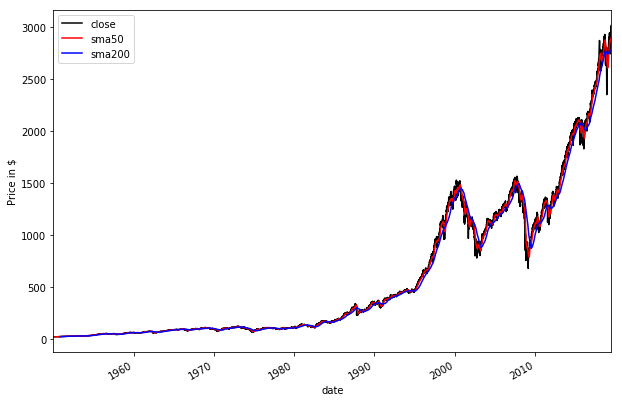

In [8]:
fig = plt.figure()
axes = fig.add_subplot(111,  ylabel='Price in $')

ts['close'].plot(ax=axes, label='close', color='k')
ts['sma50'].plot(ax=axes, label='sma50', color='r')
ts['sma200'].plot(ax=axes, label='sma200', color='b')
plt.legend(loc='best')

Create Trade Log (tlog); Create Daily Balance (dbal)

In [9]:
tlog = pf.TradeLog()
dbal = pf.DailyBal()

Algo: Buy when 50 day ma crosses above 200 day ma.  Sell when 50 day ma crosses below 200 day ma. 

In [10]:
tlog.cash = capital
start_flag = True
end_flag = False

import time
t0 = time.time()

"""
# This is the slowest (2.42 s)
for i in range(len(ts.index)):

    date = ts.index[i]
    high = ts['high'][i]
    low = ts['low'][i]
    close = ts['close'][i]
    sma50 = ts['sma50'][i]
    sma200 = ts['sma200'][i]

# This is still slow (2.53 s)
for i, (index, row) in enumerate(ts.iterrows()):

    date = index
    high = row['high']
    low = row['low']
    close = row['close']
    sma50 = row['sma50']
    sma200 = row['sma200']


# using .at[] is fast (832 ms)
for i, index in enumerate(ts.index):

    date = index
    high = ts.at[index, 'high']
    low = ts.at[index, 'low']
    close = ts.at[index, 'close']
    sma50 = ts.at[index, 'sma50']
    sma200 = ts.at[index, 'sma200']

# using itertuples is fastest for looping (378 ms)
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    high = row.high
    low = row.low
    close = row.close
    sma50 = row.sma50
    sma200 = row.sma200
"""

for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    high = row.high
    low = row.low
    close = row.close
    sma50 = row.sma50
    sma200 = row.sma200
    end_flag = True if (i == len(ts) - 1) else False
    trade_state = None
    shares = 0
        
    if pd.isnull(sma200) or date < start:
        continue
    elif start_flag:
        start_flag = False
        # set start and end
        start = date
        end = ts.index[-1]

    # buy
    if (tlog.num_open_trades() == 0
        and sma50 > sma200 and ts['sma50'][i-1] <= ts['sma200'][i-1] 
        and not end_flag):

        # enter buy in trade log
        shares = tlog.enter_trade(date, close)  
    # sell
    elif ((tlog.num_open_trades() > 0
           and sma50 < sma200 and ts['sma50'][i-1] >= ts['sma200'][i-1])
           or end_flag):

        # enter sell in trade log
        shares = tlog.exit_trade(date, close)

    if shares > 0:
        trade_state = pf.TradeState.OPEN
        print("{0} BUY  {1} {2} @ {3:.2f}".format(
              date, shares, symbol, close))
    elif shares < 0:
        trade_state = pf.TradeState.CLOSE
        print("{0} SELL {1} {2} @ {3:.2f}".format(
              date, shares, symbol, close))
    else:
        trade_state = pf.TradeState.HOLD

    # record daily balance
    dbal.append(date, high, low, close,
                tlog.shares, tlog.cash,
                trade_state)    

t1 = time.time()
total = t1-t0
print(total)
        

1953-12-21 00:00:00 BUY  400 ^GSPC @ 24.95
1956-10-26 00:00:00 BUY  400 ^GSPC @ 46.27
1957-06-03 00:00:00 BUY  391 ^GSPC @ 47.37
1957-09-26 00:00:00 BUY  391 ^GSPC @ 42.57
1958-05-08 00:00:00 BUY  378 ^GSPC @ 43.99
1959-10-30 00:00:00 BUY  378 ^GSPC @ 57.52
1959-12-30 00:00:00 BUY  364 ^GSPC @ 59.77
1960-02-15 00:00:00 BUY  364 ^GSPC @ 55.17
1961-01-04 00:00:00 BUY  344 ^GSPC @ 58.36
1962-05-07 00:00:00 BUY  344 ^GSPC @ 66.02
1963-01-03 00:00:00 BUY  356 ^GSPC @ 63.72
1965-07-22 00:00:00 BUY  356 ^GSPC @ 83.85
1965-09-17 00:00:00 BUY  331 ^GSPC @ 90.05
1966-04-28 00:00:00 BUY  331 ^GSPC @ 91.13
1967-02-03 00:00:00 BUY  346 ^GSPC @ 87.36
1968-02-27 00:00:00 BUY  346 ^GSPC @ 90.53
1968-05-17 00:00:00 BUY  323 ^GSPC @ 96.90
1969-03-13 00:00:00 BUY  323 ^GSPC @ 98.39
1969-05-27 00:00:00 BUY  307 ^GSPC @ 103.57
1969-06-23 00:00:00 BUY  307 ^GSPC @ 96.23
1970-10-22 00:00:00 BUY  354 ^GSPC @ 83.38
1971-09-24 00:00:00 BUY  354 ^GSPC @ 98.15
1972-01-26 00:00:00 BUY  339 ^GSPC @ 102.50
1973-04-1

Retrieve raw log and trade log DataFrames

In [11]:
rlog = tlog.get_log_raw()
tlog = tlog.get_log()

In [12]:
rlog.tail()

,date,price,shares,entry_exit
65,2016-01-11,1923.67,385,exit
66,2016-04-25,2087.79,355,entry
67,2018-12-07,2633.08,355,exit
68,2019-04-01,2867.19,326,entry
69,2019-07-24,3019.56,326,exit


In [13]:
tlog.tail(10)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total
25,1999-11-11,1381.46,2000-10-30,1398.66,17.20,3904.42,227,307653.51
26,2003-05-14,939.28,2004-08-18,1095.17,155.89,52690.82,338,360344.34
27,2004-11-05,1166.17,2006-07-19,1259.81,93.64,29683.88,317,390028.22
28,2006-09-12,1313.00,2007-12-21,1484.46,171.46,52123.83,304,442152.05
29,2009-06-23,895.10,2010-07-02,1022.58,127.48,64377.42,505,506529.47
30,2010-10-22,1183.08,2011-08-12,1178.81,-4.27,-1861.68,436,504667.80
31,2012-01-31,1312.41,2015-08-28,1988.87,676.46,265172.30,392,769840.10
32,2015-12-21,2021.15,2016-01-11,1923.67,-97.48,-37529.79,385,732310.31
33,2016-04-25,2087.79,2018-12-07,2633.08,545.29,193577.96,355,925888.27
34,2019-04-01,2867.19,2019-07-24,3019.56,152.37,49672.66,326,975560.93


In [14]:
dbal = dbal.get_log()
dbal.tail()

,high,low,close,shares,cash,state
date,,,,,,
2019-07-18,978623.64,970411.72,977590.25,326,1184.35,1
2019-07-19,981146.88,971314.75,971559.25,326,1184.35,1
2019-07-22,976155.80,971572.22,974304.14,326,1184.35,1
2019-07-23,981107.72,975454.93,980967.56,326,1184.35,1
2019-07-24,985560.93,985560.93,985560.93,0,985560.93,0


Generate strategy stats - display all available stats

In [15]:
stats = pf.stats(ts, tlog, dbal, start, end, capital)
pf.print_full(stats)

start                                                  1950-10-18
end                                                    2019-07-24
beginning_balance                                           10000
ending_balance                                          985560.93
total_net_profit                                        975560.93
gross_profit                                           1034134.76
gross_loss                                              -58573.82
profit_factor                                               17.66
return_on_initial_capital                                 9755.61
annual_return_rate                                           6.90
trading_period                           68 years 9 months 6 days
pct_time_in_market                                          67.10
total_num_trades                                               35
num_winning_trades                                             27
num_losing_trades                                               8
num_even_t

Run Benchmark

In [16]:
benchmark = pf.Benchmark(symbol, capital, start, end, use_adj)
benchmark.run()

1950-10-18 00:00:00 BUY  499 ^GSPC @ 20.01
2019-07-24 00:00:00 SELL 499 ^GSPC @ 3019.56


Retrieve benchmark logs

In [17]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

Generate benchmark stats

In [18]:
benchmark.stats = benchmark.stats()
pf.print_full(benchmark.stats)

start                                                  1950-10-18
end                                                    2019-07-24
beginning_balance                                           10000
ending_balance                                         1506775.48
total_net_profit                                       1496775.48
gross_profit                                           1496775.48
gross_loss                                                   0.00
profit_factor                                                1000
return_on_initial_capital                                14967.75
annual_return_rate                                           7.57
trading_period                           68 years 9 months 6 days
pct_time_in_market                                         100.00
total_num_trades                                                1
num_winning_trades                                              1
num_losing_trades                                               0
num_even_t

Plot Equity Curves: Strategy vs Benchmark

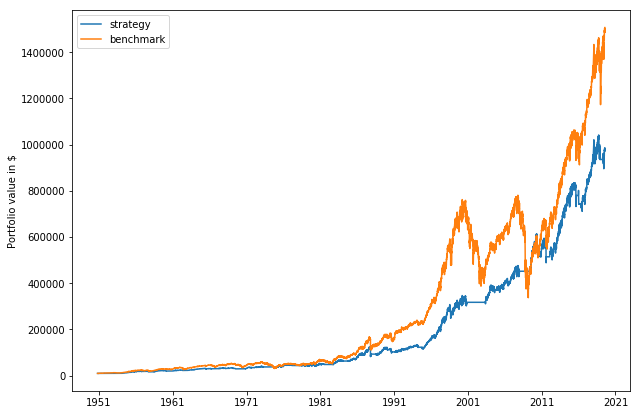

In [19]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

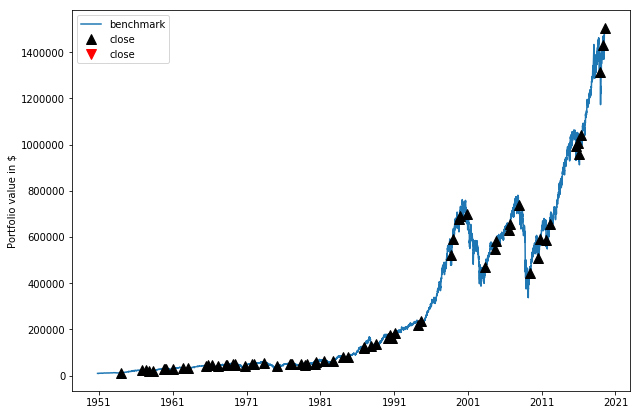

In [20]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,6.90,7.57
max_closed_out_drawdown,-33.21,-56.77
drawdown_annualized_return,-4.81,-7.50
drawdown_recovery,-0.15,-1.42
best_month,14.94,23.49
worst_month,-29.53,-29.55
sharpe_ratio,0.67,0.56
sortino_ratio,0.69,0.72
monthly_std,2.94,4.13


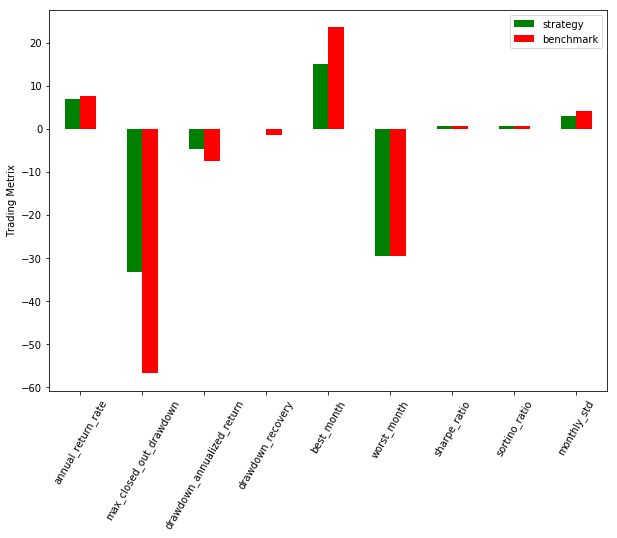

In [21]:
metrics = ('annual_return_rate',
           'max_closed_out_drawdown',
           'drawdown_annualized_return',
           'drawdown_recovery',
           'best_month',
           'worst_month',
           'sharpe_ratio',
           'sortino_ratio',
           'monthly_std')
df = pf.plot_bar_graph(stats, benchmark.stats, *metrics)
df